# TODO

- ~~noisy~~
- optimalizace diskretnich hyperparam - https://arxiv.org/pdf/1706.03673.pdf

- benchmark + proc approx?
- paralelni
- expected imrpovement per second (vetsi hyperaram me stoji vic trenovani)
- v prubehu zjistim

- kernely
- acquisition funkce

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from myopt.kernels import SquaredExp, RationalQuadratic, Linear
from myopt.gaussian_process import GaussianProcess, compute_optimized_kernel

In the basic form we have $K = k(X_{\text{train}}, X_{\text{train}}), K_* = k(X_{\text{train}}, X_{\text{test}}), K_{**} = k(X_{\text{test}}, X_{\text{test}})$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

## GP regression (ignoring noisy for now)

We condition on the training data and compute the posterior for the test data $X_{\text{test}}$. Since the posterior is Gaussian, it is fully defined by its mean and covariance, which we can compute in closed form

$$
\begin{align}
    \mu_* &= K_*^T K_*^{-1} y \\
    \Sigma_* &= K_{**} - K_*^T K_*^{-1} K_*
\end{align}
$$

In [3]:
X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

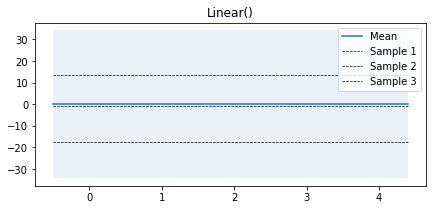

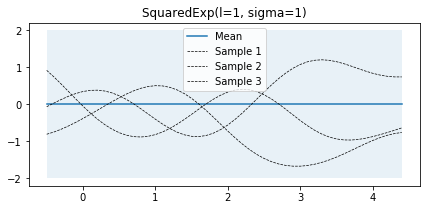

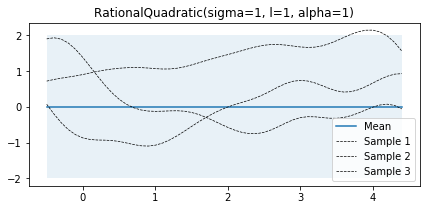

In [4]:
for k in [Linear(), SquaredExp(), RationalQuadratic()]:
    GaussianProcess(kernel=k).plot_prior(X)

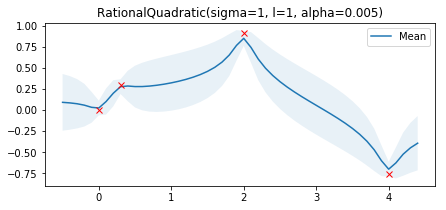

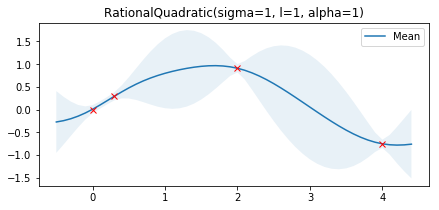

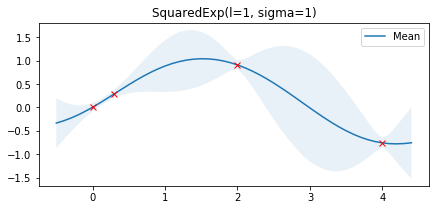

In [5]:
for kernel in [RationalQuadratic(alpha=0.005), RationalQuadratic(), SquaredExp()]: #, Linear()]:
    GaussianProcess(kernel=kernel).with_noise(.002)\
        .posterior(X, X_train, y_train).plot_posterior(num_samples=0)

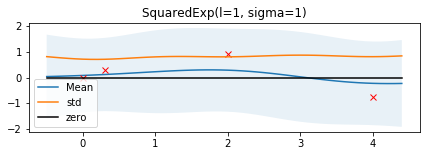

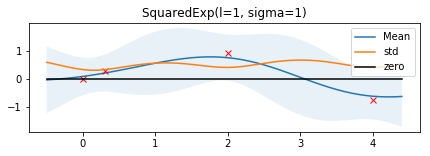

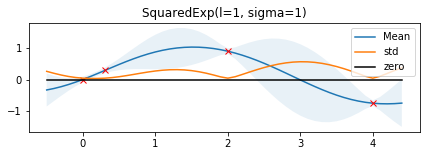

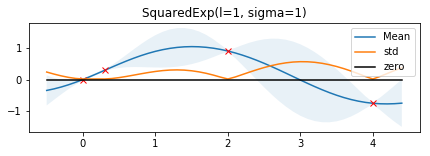

In [6]:
for noise in [2, 0.2, 0.002, 0.0002]:
    gp = GaussianProcess().with_noise(noise).posterior(X, X_train, y_train)
    plt.figure(figsize=(7,2))
    gp.plot_posterior(num_samples=0, figure=False)
    plt.plot(X, np.sqrt(np.diag(gp.cov)), label="std")
    plt.plot(X, np.zeros_like(X), label="zero", c="k")
    plt.legend()
    plt.show()

## Kernel params

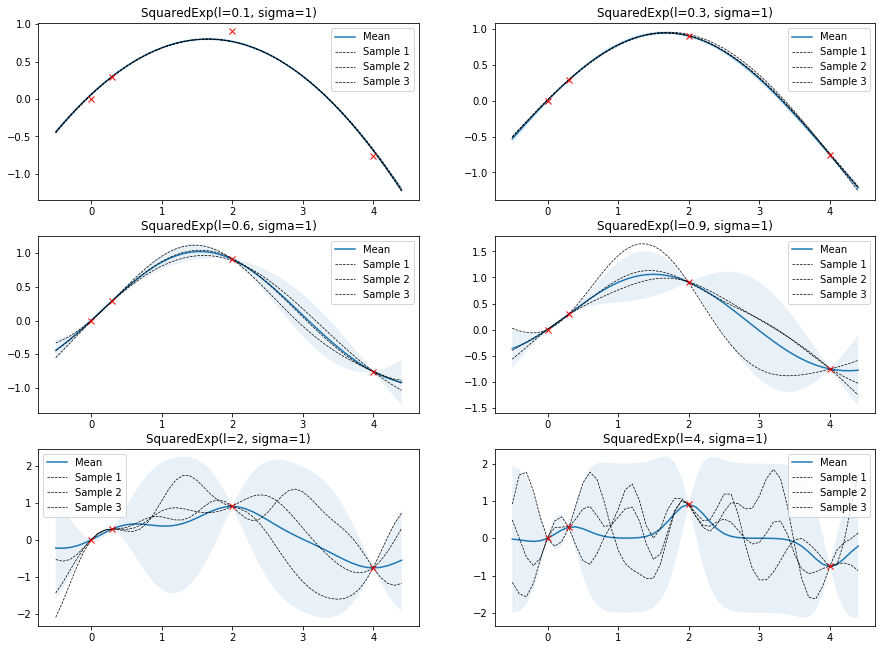

In [7]:
params = [0.1, 0.3, 0.6, 0.9, 2, 4]

gp = GaussianProcess()

plt.figure(figsize=(15,15))
for i, l in enumerate(params):
    num_rows = len(params) // 2 + 1

    plt.subplot(num_rows, 2, i+1)
    
    gp.with_kernel_params([l, 1]).fit(X_train, y_train).posterior(X).plot_posterior(figure=False)

## Optimizing kernel parameters

$$
\begin{align}
    \log p(y|X) &= \log N(y|0, K_y) \\
                &= -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log |K_y| - \frac{N}{2} \log(2 \pi)
\end{align}
$$

SquaredExp(l=77.26, sigma=1)


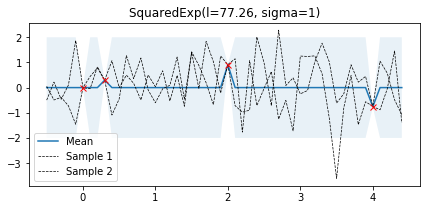

In [18]:
# Example with broken kernel optimization

X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)
kernel = SquaredExp(l=77.26, sigma=1)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

print(compute_optimized_kernel(kernel, X_train, y_train)) # ??? wtf

# plt.plot(X, np.zeros_like(X))
# plt.scatter(X_train, y_train)

a = GaussianProcess().fit(X_train, y_train)\
        .optimize_kernel().posterior(X).plot_posterior(num_samples=2)  # broken kernel opt

Broken SquaredExp optimiation

![broken img](https://i.imgur.com/Oa49O2R.png)

In [19]:
X = np.arange(-5, 5, 0.1)

noise = 0.2

# Noisy training data
X_train = np.arange(-3, 4, 1)
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

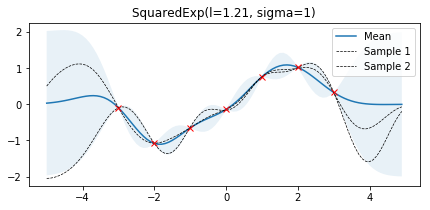

In [20]:
a = GaussianProcess().fit(X_train, y_train)\
        .optimize_kernel().posterior(X).plot_posterior(num_samples=2)

In [21]:
compute_optimized_kernel(a.kernel, X_train, y_train)

SquaredExp(l=1.21, sigma=1)

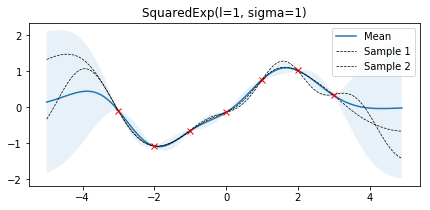

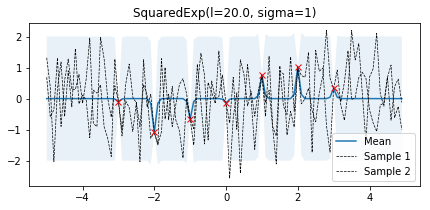

In [22]:
a = GaussianProcess().fit(X_train, y_train)\
        .posterior(X).plot_posterior(num_samples=2)

b = a.optimize_kernel().posterior(X).plot_posterior(num_samples=2)

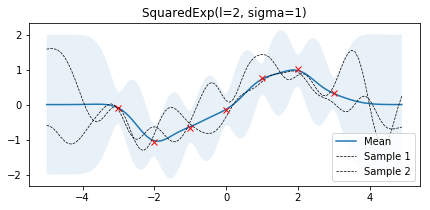

In [23]:
k = GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior(num_samples=2).kernel

In [24]:
compute_optimized_kernel(SquaredExp(2), X_train, y_train)

SquaredExp(l=1.21, sigma=1)

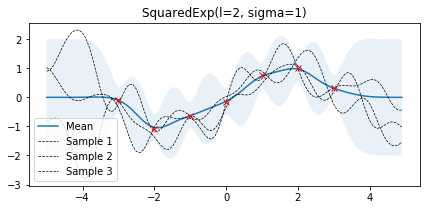

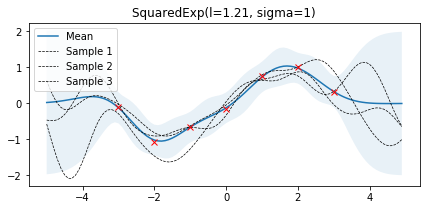

In [25]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([2, 1]).posterior(X).plot_posterior()\
        .optimize_kernel().posterior(X).plot_posterior()

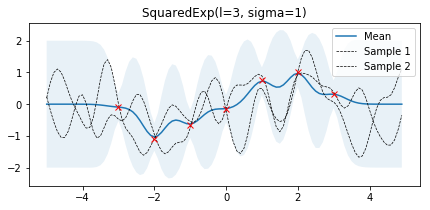

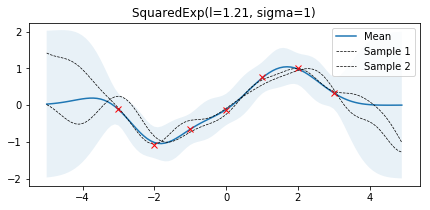

In [26]:
GaussianProcess(.05).fit(X_train, y_train)\
        .with_kernel_params([3, 1]).posterior(X).plot_posterior(num_samples=2)\
        .optimize_kernel().posterior(X).plot_posterior(num_samples=2)

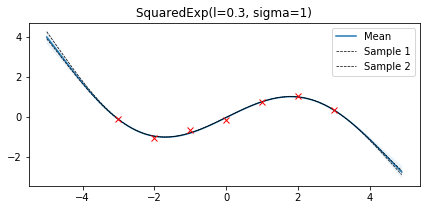

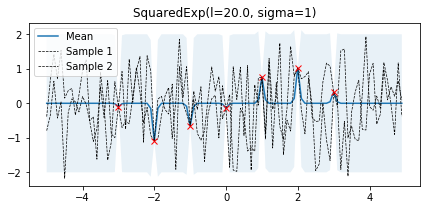

In [27]:
GaussianProcess().fit(X_train, y_train)\
        .with_kernel_params([0.3, 1]).posterior(X).plot_posterior(num_samples=2)\
        .optimize_kernel().posterior(X).plot_posterior(num_samples=2)

# Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [28]:
from myopt.bayesian_optimization import bo_minimize
from myopt.acquisition_functions import expected_improvement
from myopt.bayesian_optimization import propose_location

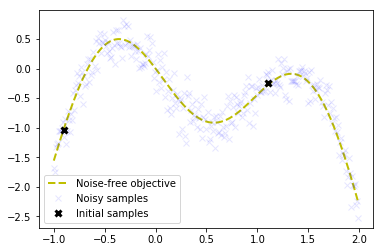

In [29]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
y_init = f(X_init)

# Dense grid of points within bounds
X_true = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
y_true = f(X_true, 0)

# Plot optimization objective with noise level 
plt.plot(X_true, y_true, 'y--', lw=2, label='Noise-free objective')
plt.plot(X_true, f(X_true), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

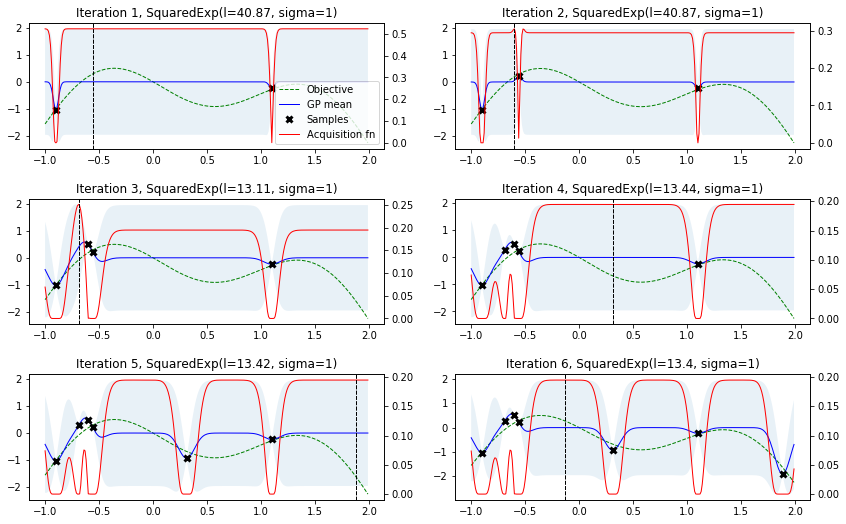

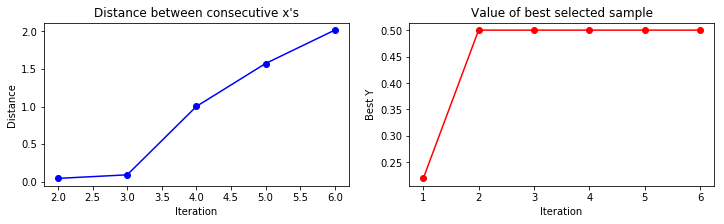

In [33]:
bo_minimize(f, noise, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=6, optimize_kernel=True)

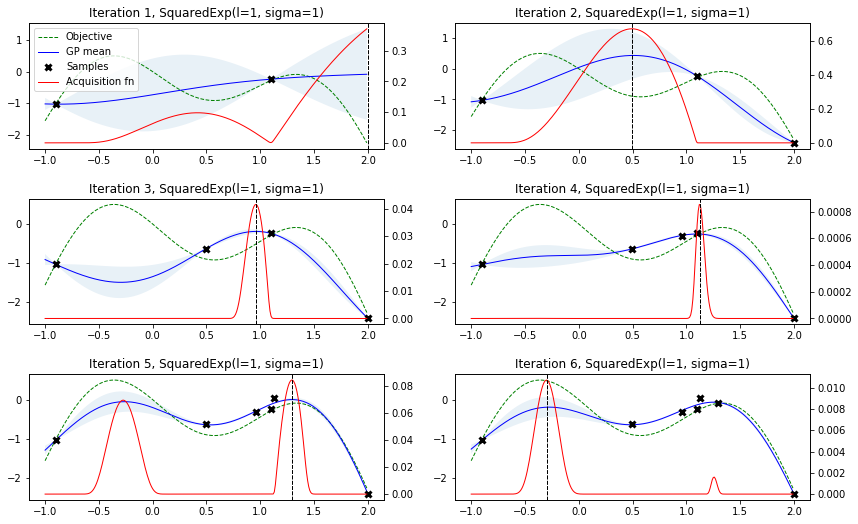

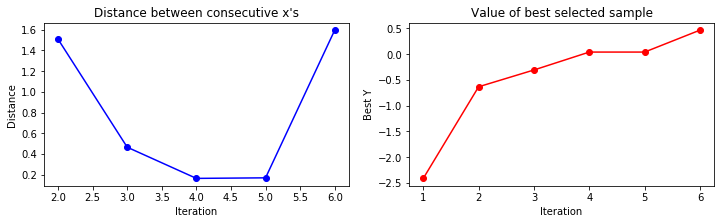

In [31]:
bo_minimize(f, noise, bounds, X_init, y_init, X_true=X_true, y_true=y_true, n_iter=6, optimize_kernel=False)

# Matrix inverse timing

In [34]:
import torch

In [35]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = np.random.randn(n, n)
    %time inv(m)

Wall time: 0 ns
Wall time: 998 µs
Wall time: 38.9 ms
Wall time: 254 ms
Wall time: 733 ms
Wall time: 1.47 s


In [36]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = torch.from_numpy(np.random.randn(n, n))
    %time torch.inverse(m)

Wall time: 0 ns
Wall time: 987 µs
Wall time: 28 ms
Wall time: 160 ms
Wall time: 512 ms
Wall time: 1.12 s


In [37]:
for n in [10, 100, 1000, 2000, 3000, 4000]:
    m = torch.from_numpy(np.random.randn(n, n)).cuda()
    %time torch.inverse(m)

Wall time: 450 ms
Wall time: 10.5 ms
Wall time: 51.9 ms
Wall time: 150 ms
Wall time: 322 ms
Wall time: 578 ms


## GP benchmarks

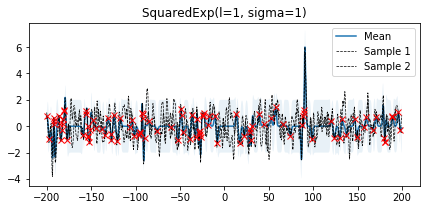

In [38]:
X = np.arange(-200, 200, 0.2)

noise = 0.2

# Noisy training data
X_train = 400*np.random.rand(100) - 200
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

%prun GaussianProcess().fit(X_train, y_train).posterior(X).plot_posterior(num_samples=2)